In [2]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import sys
print(sys.version)
from tensorflow import keras 
print(keras.__version__)

3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]
2.2.4-tf


- Python version 3.6이어야 함.

# LSTM

In [6]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import sequence

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

#### 자료 불러오기

In [7]:
# data 불러오기
(X_train, Y_train), (X_test, Y_test) = reuters.load_data(num_words = 100, test_split = 0.2) #80:20

# 데이터 확인
category = np.max(Y_train) + 1
print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')
print( X_train[0] )
print( len(X_train[0]) )
#각 단어가 나타나는 빈도 순위(1:빈도 가장 많음)

2113536/2110848 [==============================] - 0s 0us/step
46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 2, 2, 8, 43, 10, 2, 5, 25, 2, 2, 5, 2, 2, 16, 2, 2, 90, 67, 7, 89, 5, 19, 2, 6, 19, 2, 15, 90, 67, 84, 22, 2, 26, 7, 48, 4, 49, 8, 2, 39, 2, 2, 6, 2, 6, 83, 11, 15, 22, 2, 11, 15, 7, 48, 9, 2, 2, 2, 6, 2, 6, 2, 11, 15, 22, 2, 44, 11, 15, 16, 8, 2, 2, 90, 67, 52, 29, 2, 30, 32, 2, 6, 2, 15, 17, 12]
87


In [8]:
# 데이터 전처리
x_train = sequence.pad_sequences(X_train, maxlen=100) #길이 100으로, 모자라면 0을 채워줌(t=1부터 100까지)
x_test = sequence.pad_sequences(X_test, maxlen=100)
print( len(X_train[0]) )
print( len(x_train[0]) )

y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)
print(y_train.shape, y_test.shape)

87
100
(8982, 46) (2246, 46)


In [9]:
x_train[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  2,  8,
       43, 10,  2,  5, 25,  2,  2,  5,  2,  2, 16,  2,  2, 90, 67,  7, 89,
        5, 19,  2,  6, 19,  2, 15, 90, 67, 84, 22,  2, 26,  7, 48,  4, 49,
        8,  2, 39,  2,  2,  6,  2,  6, 83, 11, 15, 22,  2, 11, 15,  7, 48,
        9,  2,  2,  2,  6,  2,  6,  2, 11, 15, 22,  2, 44, 11, 15, 16,  8,
        2,  2, 90, 67, 52, 29,  2, 30, 32,  2,  6,  2, 15, 17, 12])

In [10]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [11]:
x_test[0]

array([ 5,  2,  7,  2, 48,  9,  2,  7,  2,  2,  2,  2,  2, 97,  2,  2,  7,
        4,  2, 98,  2,  2,  2, 25, 39,  2, 22,  2,  2,  2,  2, 59, 20,  6,
        2, 61, 11, 15, 58,  2, 26, 10, 67,  7,  4,  2, 98, 43, 88,  2,  2,
       12, 20,  6, 19,  2, 35, 15, 10,  9,  2,  2,  2,  2, 21,  4,  2,  2,
        2, 51, 16,  2,  2, 16,  2,  4, 99, 29,  5,  4,  2,  2, 48, 10,  9,
        2, 23,  2, 47, 20,  2, 27, 56,  2,  2,  5,  2,  2, 17, 12])

In [12]:
y_test[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

#### 모델 설정(adam optimizer)

In [13]:
#adam optimizer
seed=0
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)

# 모델의 설정
model = Sequential()
model.add(Embedding(1000, 100)) #Embedding: sparse 벡터를 변환 / 1000: 단어의 총 개수 / 100: 길이 100
model.add(LSTM(100, activation = 'tanh')) #t=1부터 100까지
model.add(Dense(46, activation = 'softmax'))

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['accuracy'])

In [14]:
# 모델 학습
train_history = model.fit(x_train, y_train, batch_size=100,
                         epochs=30, validation_data=(x_test, y_test))

Train on 8982 samples, validate on 2246 samples
Epoch 1/30
8982/8982 [==============================] - 11s 1ms/sample - loss: 2.6046 - accuracy: 0.3456 - val_loss: 2.4112 - val_accuracy: 0.3620
Epoch 2/30
8982/8982 [==============================] - 9s 997us/sample - loss: 2.1873 - accuracy: 0.4463 - val_loss: 2.0798 - val_accuracy: 0.4849
Epoch 3/30
8982/8982 [==============================] - 9s 978us/sample - loss: 2.0559 - accuracy: 0.4899 - val_loss: 2.0299 - val_accuracy: 0.5062
Epoch 4/30
8982/8982 [==============================] - 9s 993us/sample - loss: 2.0336 - accuracy: 0.4984 - val_loss: 2.0036 - val_accuracy: 0.5125
Epoch 5/30
8982/8982 [==============================] - 9s 971us/sample - loss: 1.9400 - accuracy: 0.5041 - val_loss: 1.8905 - val_accuracy: 0.5134
Epoch 6/30
8982/8982 [==============================] - 9s 955us/sample - loss: 1.8571 - accuracy: 0.5111 - val_loss: 1.8701 - val_accuracy: 0.5307
Epoch 7/30
8982/8982 [==============================] - 9s 977us/

In [15]:
# 학습셋 정확도 
print('Train accuracy: %.4f' % (model.evaluate(x_train, y_train)[1]))

8982/8982 [==============================] - 4s 465us/sample - loss: 1.1339 - accuracy: 0.7035
Train accuracy: 0.7035


In [16]:
# 테스트셋 정확도 
print('Test accuracy: %.4f' % (model.evaluate(x_test, y_test)[1]))

2246/2246 [==============================] - 1s 483us/sample - loss: 1.4115 - accuracy: 0.6478
Test accuracy: 0.6478


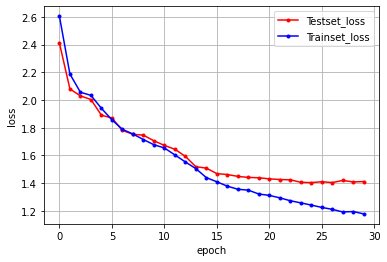

In [17]:
# 오차 비교
vloss = train_history.history['val_loss']
loss = train_history.history['loss']

x_len = np.arange(len(loss))
plt.plot(x_len, vloss, marker='.', c='red', label='Testset_loss')
plt.plot(x_len, loss, marker='.', c='blue', label='Trainset_loss')

plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

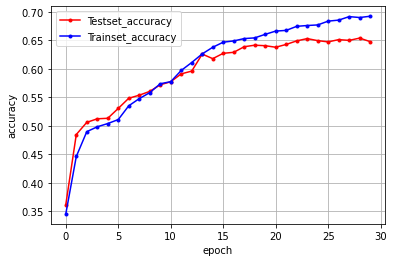

In [18]:
# 정확도
vacc = train_history.history['val_accuracy']
acc = train_history.history['accuracy']

x_len = np.arange(len(acc))
plt.plot(x_len, vacc, marker='.', c='red', label='Testset_accuracy')
plt.plot(x_len, acc, marker='.', c='blue', label='Trainset_accuracy')

plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()